In [1]:
from __future__ import print_function
import ROOT
from ROOT import TChain
from larcv import larcv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Welcome to JupyROOT 6.19/01


In [2]:
ROOT.TFile.Open('C3/test_40k.root').ls()

TFile**		C3/test_40k.root	
 TFile*		C3/test_40k.root	
  KEY: TTree	image2d_data_tree;1	data tree
  KEY: TTree	particle_mctruth_tree;1	mctruth tree


40000 entries found!
Object type: <ROOT.larcv::EventImage2D object at 0x55f9d0f06d20>


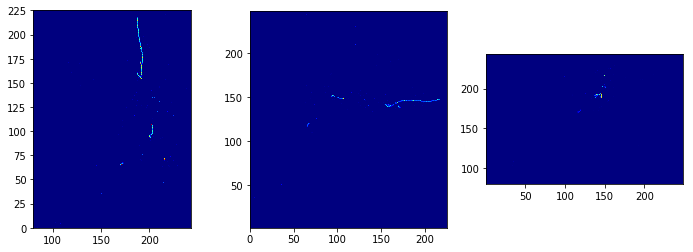

In [3]:
from larcv import larcv

# Create TChain, count # of entries
chain_image2d = ROOT.TChain('image2d_data_tree')
chain_image2d.AddFile('C3/test_40k.root')
print(chain_image2d.GetEntries(),'entries found!')

# Get a specific event (first entry)
chain_image2d.GetEntry(0)
cpp_object = chain_image2d.image2d_data_branch
print('Object type:',cpp_object)

# Get std::vector
image2d_array = cpp_object.as_vector()
# Dump images
fig, axes = plt.subplots(1, image2d_array.size(), figsize=(12,4), facecolor='w')
for index,image2d in enumerate(image2d_array):
    image2d_numpy = larcv.as_ndarray(image2d)
    axes[index].imshow(image2d_numpy, interpolation='none',cmap='jet')
    # Find bounds for non-zero pixels + padding of 5 pixels
    nz_pixels=np.where(image2d_numpy>0.0)
    ylim = (np.min(nz_pixels[0])-5,np.max(nz_pixels[0])+5)
    xlim = (np.min(nz_pixels[1])-5,np.max(nz_pixels[1])+5)
    # Adjust for allowed image range
    ylim = (np.max((ylim[0],0)), np.min((ylim[1],image2d_numpy.shape[1]-1)))
    xlim = (np.max((xlim[0],0)), np.min((xlim[1],image2d_numpy.shape[0]-1)))
    # Set range
    axes[index].set_ylim(ylim)
    axes[index].set_xlim(xlim)
plt.show()

In [4]:
# Create TChain, count # of entries
chain_particle = ROOT.TChain('particle_mctruth_tree')
chain_particle.AddFile('C3/test_40k.root')
print(chain_image2d.GetEntries(),'entries found!')

# Get a specific event (first entry)
chain_particle.GetEntry(0)
cpp_object = chain_particle.particle_mctruth_branch
print('Object type: {}\n'.format(str(cpp_object)))

# Dump particle information
print('Checking particle information for 1st entry...')
for particle in cpp_object.as_vector():
    print('PDG Code: {}'.format(particle.pdg_code()))
    print('Initial energy: {:.3} GeV'.format(particle.energy_init()))

40000 entries found!
Object type: <ROOT.larcv::EventParticle object at 0x55f9d176fa50>

Checking particle information for 1st entry...
PDG Code: 11
Initial energy: 0.138 GeV


In [5]:
pdg_array      = np.zeros([chain_particle.GetEntries()],dtype=np.int32)
energy_array   = np.zeros([chain_particle.GetEntries()],dtype=np.float64)
momentum_array = np.zeros([chain_particle.GetEntries()],dtype=np.float64)

for index in range(chain_particle.GetEntries()):
    chain_particle.GetEntry(index)
    particle = chain_particle.particle_mctruth_branch.as_vector().front()
    pdg = int(particle.pdg_code())
    total_energy   = particle.energy_init() * 1000.
    kinetic_energy = total_energy - larcv.ParticleMass(pdg)
    momentum = np.sqrt(np.power(total_energy,2) - np.power(larcv.ParticleMass(pdg),2))
    
    pdg_array[index]      = pdg
    energy_array[index]   = kinetic_energy
    momentum_array[index] = momentum
    
    #if momentum > 800:
    #    print(pdg,kinetic_energy,momentum)

import pandas as pd
df = pd.DataFrame(data={'pdg' : pdg_array, 'energy' : energy_array, 'momentum' : momentum_array})

In [6]:
pdg_list, pdg_counts = np.unique(df.pdg.values,return_counts=True)

print('PDGs found: {}'.format(pdg_list))
print('PDG counts: {}'.format(pdg_counts))

PDGs found: [  11   13   22  211 2212]
PDG counts: [8000 8000 8000 8000 8000]


In [7]:
PDG2NAME = {11   : 'electron',
            22   : 'gamma',
            13   : 'muon',
            211  : 'pion',
            2212 : 'proton'}
for pdg in pdg_list:
    sub_df = df.query('pdg=={}'.format(pdg))
    min_value = sub_df.momentum.values.min()
    max_value = sub_df.momentum.values.max()
    print('{:10s} momentum range: {:.3g} => {:.3g} MeV/c'.format(PDG2NAME[pdg], min_value, max_value))

electron   momentum range: 35.6 => 800 MeV/c
muon       momentum range: 90 => 800 MeV/c
gamma      momentum range: 35.1 => 800 MeV/c
pion       momentum range: 105 => 800 MeV/c
proton     momentum range: 276 => 800 MeV/c


/home/dell/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


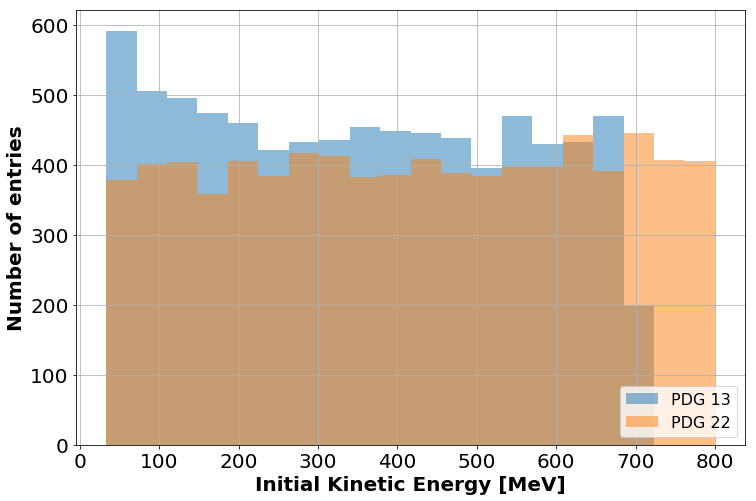

In [8]:
fig, ax = plt.subplots(figsize=(12,8),facecolor='w')

pdg_list = [13,22]
sub_df = df.query('pdg in {}'.format(pdg_list))
min_value = sub_df.energy.values.min()
max_value = sub_df.energy.values.max()

for pdg in pdg_list:
    pdg_df = sub_df.query('pdg == {}'.format(pdg))
    values = pdg_df.energy.values
    plt.hist(values, bins=20, range=(min_value,max_value), label='PDG {}'.format(pdg), alpha=0.5)

plt.tick_params(labelsize=20)
plt.grid(True,which='both')
plt.xlabel('Initial Kinetic Energy [MeV]',fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel('Number of entries',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=4)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
    
plt.show()

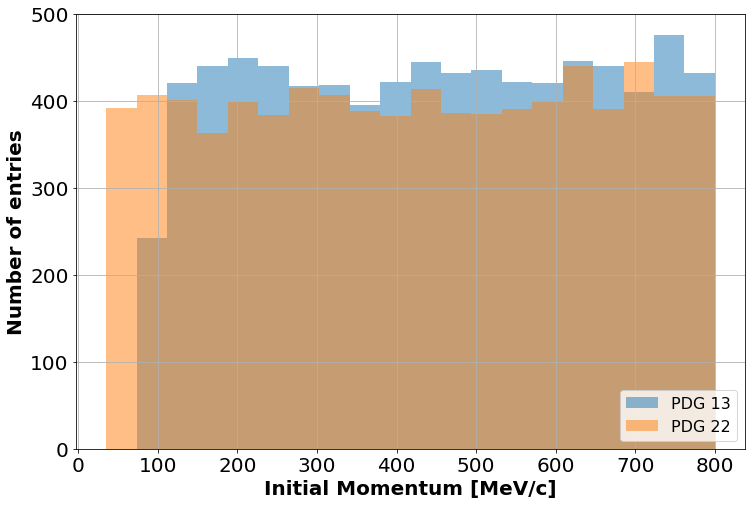

In [9]:
fig, ax = plt.subplots(figsize=(12,8),facecolor='w')

pdg_list = [13,22]
sub_df = df.query('pdg in {}'.format(pdg_list))
min_value = sub_df.momentum.values.min()
max_value = sub_df.momentum.values.max()

for pdg in pdg_list:
    pdg_df = sub_df.query('pdg == {}'.format(pdg))
    values = pdg_df.momentum.values
    plt.hist(values, bins=20, range=(min_value,max_value), label='PDG {}'.format(pdg), alpha=0.5)

plt.tick_params(labelsize=20)
plt.grid(True,which='both')
plt.xlabel('Initial Momentum [MeV/c]',fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel('Number of entries',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=4)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
    
plt.show()

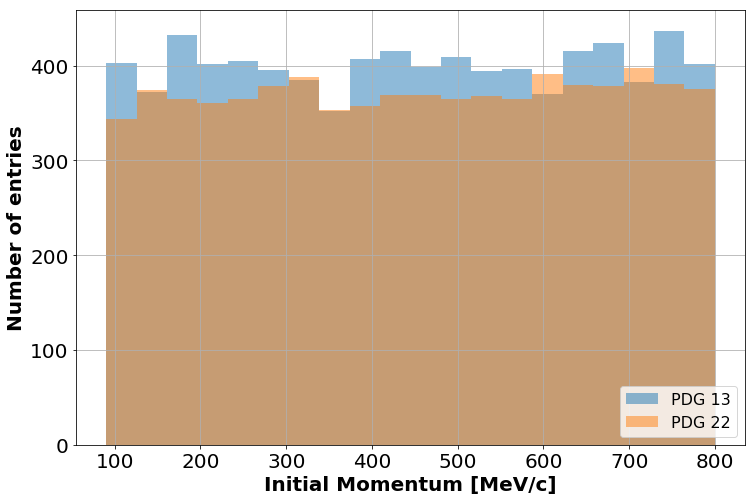

In [10]:
fig, ax = plt.subplots(figsize=(12,8),facecolor='w')

pdg_list = [13,22]
sub_df = df.query('pdg in {} and momentum > 90'.format(pdg_list))
min_value = sub_df.momentum.values.min()
max_value = sub_df.momentum.values.max()

for pdg in pdg_list:
    pdg_df = sub_df.query('pdg == {}'.format(pdg))
    values = pdg_df.momentum.values
    plt.hist(values, bins=20, range=(min_value,max_value), label='PDG {}'.format(pdg), alpha=0.5)

plt.tick_params(labelsize=20)
plt.grid(True,which='both')
plt.xlabel('Initial Momentum [MeV/c]',fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel('Number of entries',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=4)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
    
plt.show()

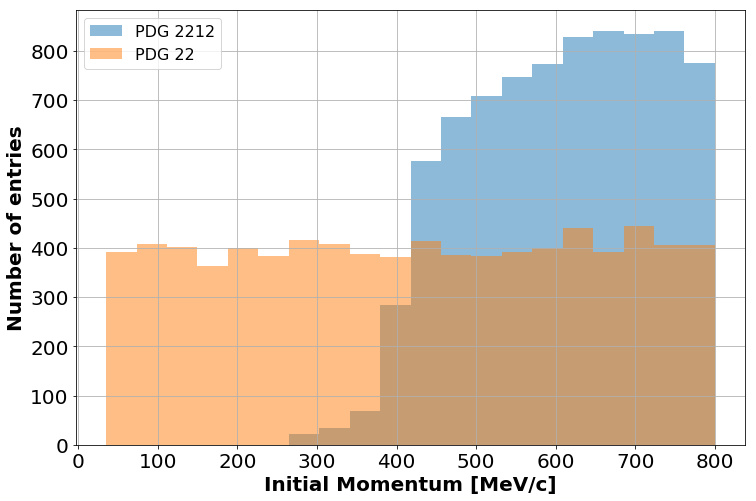

In [11]:
fig, ax = plt.subplots(figsize=(12,8),facecolor='w')

pdg_list = [2212,22]
sub_df = df.query('pdg in {}'.format(pdg_list))
min_value = sub_df.momentum.values.min()
max_value = sub_df.momentum.values.max()

for pdg in pdg_list:
    pdg_df = sub_df.query('pdg == {}'.format(pdg))
    values = pdg_df.momentum.values
    plt.hist(values, bins=20, range=(min_value,max_value), label='PDG {}'.format(pdg), alpha=0.5)

plt.tick_params(labelsize=20)
plt.grid(True,which='both')
plt.xlabel('Initial Momentum [MeV/c]',fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel('Number of entries',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=2)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
    
plt.show()

In [12]:
for index,image2d in enumerate(image2d_array):
    print(image2d.meta().dump())

ProjectionID 0 (rows,cols) = (256,256) ... Distance Unit: 1 ... Left Bottom => Right Top     (0,0) => (128,128)

ProjectionID 1 (rows,cols) = (256,256) ... Distance Unit: 1 ... Left Bottom => Right Top     (0,0) => (128,128)

ProjectionID 2 (rows,cols) = (256,256) ... Distance Unit: 1 ... Left Bottom => Right Top     (0,0) => (128,128)



In [13]:
sub_df = df.query('pdg==2212 and energy < 50')
print('Found {} entries'.format(sub_df.index.size))
print(sub_df)

Found 31 entries
        pdg     energy    momentum
32020  2212  41.263582  281.310530
32393  2212  49.737159  309.528281
32542  2212  44.556907  292.571902
32850  2212  43.212706  288.024107
34161  2212  46.890996  300.319476
34168  2212  42.130230  284.313542
34355  2212  41.539873  282.271083
34422  2212  39.836204  276.299325
34826  2212  46.279951  298.308904
35047  2212  42.837546  286.743088
35094  2212  46.434549  298.818752
35617  2212  49.411610  308.487557
35871  2212  49.498857  308.766780
36260  2212  48.056076  304.119600
36462  2212  43.842835  290.164104
36599  2212  42.882855  286.898080
36987  2212  46.859598  300.216461
37361  2212  48.909169  306.875088
37446  2212  49.006110  307.186792
37599  2212  48.831407  306.624842
37606  2212  41.447842  281.951462
37618  2212  49.868782  309.948164
38329  2212  46.325785  298.460141
38539  2212  48.387375  305.192368
38578  2212  44.501460  292.385587
38712  2212  46.190251  298.012721
38973  2212  44.025635  290.782224
390

40000 entries found!
Object type: <ROOT.larcv::EventImage2D object at 0x55f9d0e8c3d0>


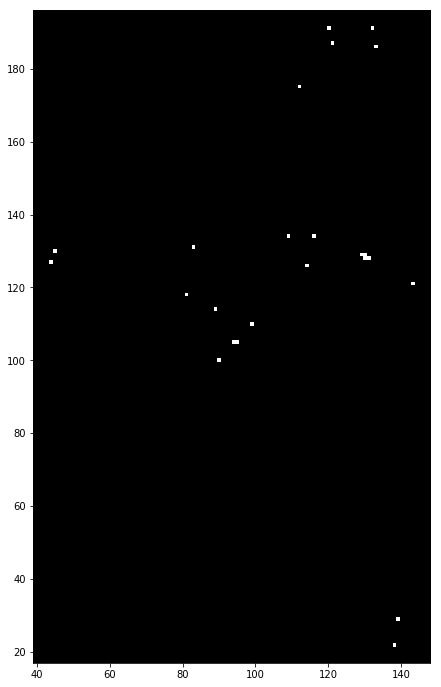

In [15]:
# Create TChain, count # of entries
chain_image2d = ROOT.TChain('image2d_data_tree')
chain_image2d.AddFile('C3/test_40k.root')
print(chain_image2d.GetEntries(),'entries found!')

# Get a specific event (first entry)
chain_image2d.GetEntry(32020)
cpp_object = chain_image2d.image2d_data_branch
print('Object type:',cpp_object)

image2d = cpp_object.as_vector().front()

fig, ax = plt.subplots(figsize=(12,12), facecolor='w')
image2d_numpy = larcv.as_ndarray(image2d)
ax.imshow(image2d_numpy, interpolation='none', vmin=0., vmax=image2d_numpy.mean(), cmap='gray')
# Find bounds for non-zero pixels + padding of 5 pixels
nz_pixels=np.where(image2d_numpy>0.0)
ylim = (np.min(nz_pixels[0])-5,np.max(nz_pixels[0])+5)
xlim = (np.min(nz_pixels[1])-5,np.max(nz_pixels[1])+5)
# Adjust for allowed image range
ylim = (np.max((ylim[0],0)), np.min((ylim[1],image2d_numpy.shape[1]-1)))
xlim = (np.max((xlim[0],0)), np.min((xlim[1],image2d_numpy.shape[0]-1)))
# Set range
ax.set_ylim(ylim)
ax.set_xlim(xlim)
plt.show()